In [1]:
# Utilities
import os
import matplotlib.pyplot as plt
import pandas as pd
import IPython.display
from IPython.display import GeoJSON
from pydantic import BaseModel, Field

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

/home/ga888797/.pyenv/versions/3.11.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plotting

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# Catalog API

In [9]:
config = SHConfig()
config.sh_client_id = os.environ.get("CLIENT_ID")
config.sh_client_secret = os.environ.get("CLIENT_SECRET")

In [10]:
catalog = SentinelHubCatalog(config=config)
catalog

In [11]:
aoi_coords_wgs84 = [15.461282, 46.757161, 15.574922, 46.851514]
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=10)
time_interval = "2022-05-01", "2022-05-20"

In [12]:
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    # fields={
    #     "include": ["id", "properties.datetime", "properties.eo:cloud_cover", "properties.resolution"],
    #     "exclude": ["stac_version", "stac_extensions", "links"]
    # },
)

results = list(search_iterator)
print("Total number of results:", len(results))

Total number of results: 8


In [77]:
results[0]

{'stac_version': '1.0.0',
 'stac_extensions': ['https://stac-extensions.github.io/eo/v1.0.0/schema.json',
  'https://stac-extensions.github.io/projection/v1.0.0/schema.json'],
 'id': 'S2B_MSIL2A_20220520T100029_N0400_R122_T33TWM_20220520T115210',
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
  'coordinates': [[[[14.999750299725966, 46.95370017892057],
     [14.99975477253336, 45.966460192428485],
     [16.398671708415513, 45.95844011935844],
     [16.417840800814794, 46.0036998900491],
     [16.442494720512105, 46.94461260944948],
     [14.999750299725966, 46.95370017892057]]]]},
 'bbox': [14.999750299725966,
  45.95844011935844,
  16.442494720512105,
  46.95370017892057],
 'properties': {'datetime': '2022-05-20T10:07:48Z',
  'platform': 'sentinel-2b',
  'instruments': ['msi'],
  'constellation': 'sentinel-2',
  'gsd': 10,
  'eo:cloud_cover': 7.06,
  'proj:epsg': 32633,
  'proj:bbox': [49998

In [18]:
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={
        "include": ["id", "properties.datetime", "properties.eo:cloud_cover", "bbox"],
        "exclude": ["stac_version", "stac_extensions", "links"]
    },
)

results = list(search_iterator)
print("Total number of results:", len(results))

results[0]

Total number of results: 8


{'bbox': [14.999750299725966,
  45.95844011935844,
  16.442494720512105,
  46.95370017892057],
 'id': 'S2B_MSIL2A_20220520T100029_N0400_R122_T33TWM_20220520T115210',
 'properties': {'datetime': '2022-05-20T10:07:48Z', 'eo:cloud_cover': 7.06}}

## Pydantic

In [49]:
class ResultProperties(BaseModel):
    datetime: str
    eo_cloud_cover: float = Field(..., alias='eo:cloud_cover')


class Result(BaseModel):
    id: str
    properties: ResultProperties
    def __gt__(self, other):
        if isinstance(other, Result):
            if self.properties.eo_cloud_cover > other.properties.eo_cloud_cover:
                return True
            elif self.properties.eo_cloud_cover <= other.properties.eo_cloud_cover:
                return False

# class ResultsList(BaseModel):
#     results: list[Result]

In [43]:
search_results = [Result.model_validate(r) for r in results]
search_results

[Result(id='S2B_MSIL2A_20220520T100029_N0400_R122_T33TWM_20220520T115210', properties=ResultProperties(datetime='2022-05-20T10:07:48Z', eo_cloud_cover=7.06)),
 Result(id='S2B_MSIL2A_20220517T095029_N0400_R079_T33TWM_20220517T124459', properties=ResultProperties(datetime='2022-05-17T09:57:51Z', eo_cloud_cover=91.36)),
 Result(id='S2A_MSIL2A_20220515T100031_N0400_R122_T33TWM_20220515T141508', properties=ResultProperties(datetime='2022-05-15T10:07:52Z', eo_cloud_cover=6.66)),
 Result(id='S2A_MSIL2A_20220512T095031_N0400_R079_T33TWM_20220512T143915', properties=ResultProperties(datetime='2022-05-12T09:57:55Z', eo_cloud_cover=0.81)),
 Result(id='S2B_MSIL2A_20220510T100029_N0400_R122_T33TWM_20220510T122841', properties=ResultProperties(datetime='2022-05-10T10:07:45Z', eo_cloud_cover=21.39)),
 Result(id='S2B_MSIL2A_20220507T095029_N0400_R079_T33TWM_20220507T114721', properties=ResultProperties(datetime='2022-05-07T09:57:47Z', eo_cloud_cover=100.0)),
 Result(id='S2A_MSIL2A_20220505T100031_N040

In [50]:
min(search_results)

Result(id='S2B_MSIL2A_20220520T100029_N0400_R122_T33TWM_20220520T115210', properties=ResultProperties(datetime='2022-05-20T10:07:48Z', eo_cloud_cover=7.06))

# Processing API

## True color

In [54]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [87]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [88]:
true_color_imgs = request_true_color.get_data()

In [89]:
image = true_color_imgs[0]

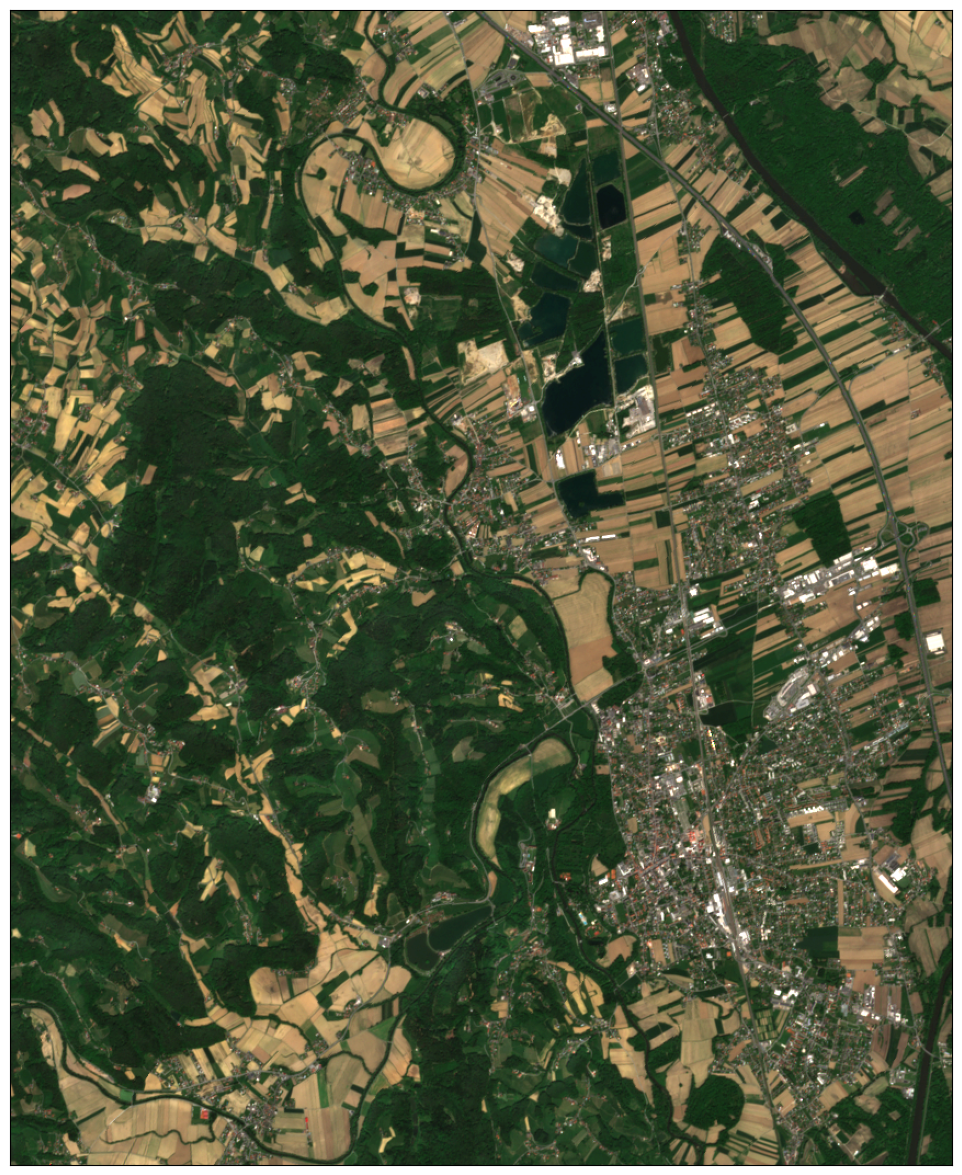

In [90]:
plot_image(
    image,
    factor=3.5 / 255,
    clip_range=(0, 1)
)

## NDVI

In [83]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}
  

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

request_ndvi_img = SentinelHubRequest(
    evalscript=evalscript_ndvi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [84]:
ndvi_img = request_ndvi_img.get_data()

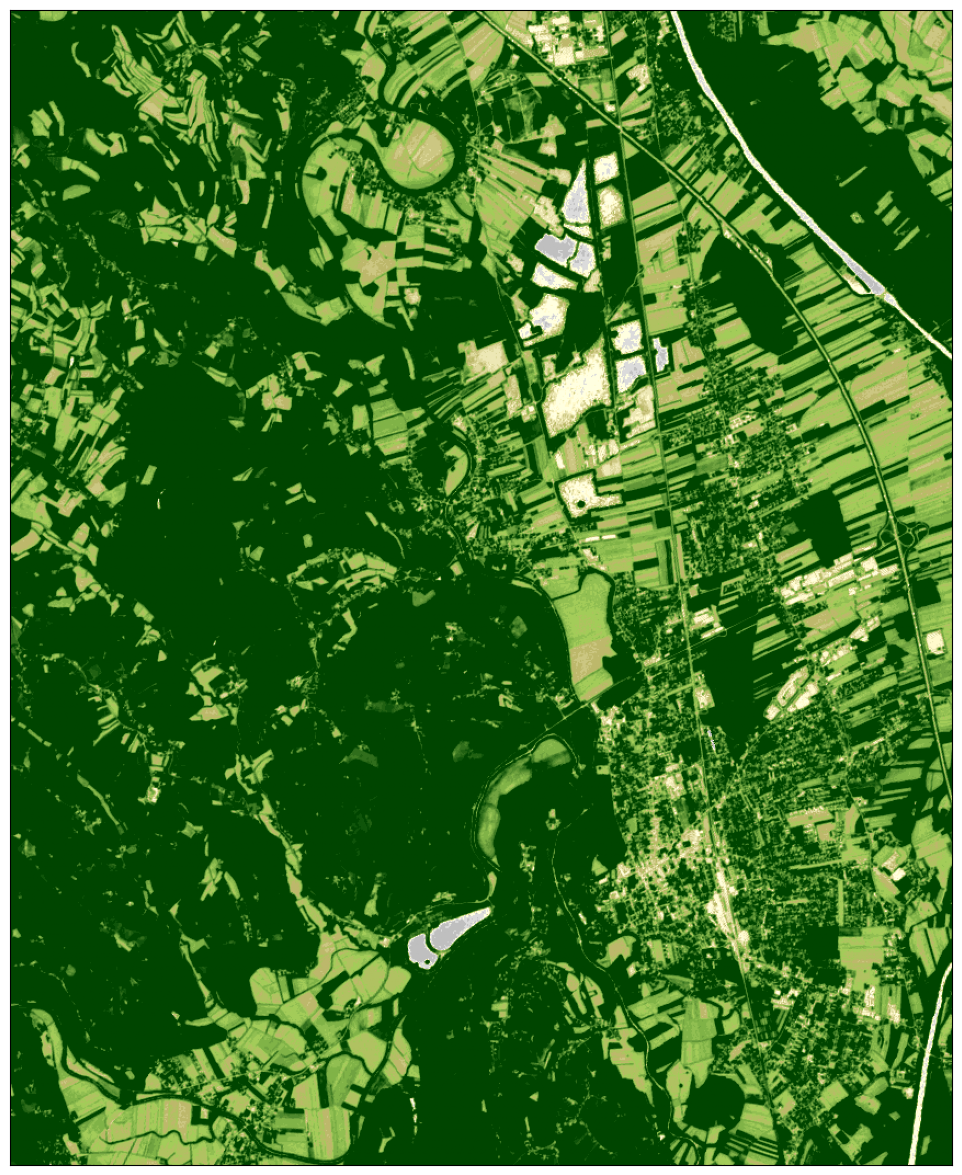

In [85]:
ndvi_image = ndvi_img[0]

plot_image(ndvi_image, factor=1 / 255)